测试数据和训练数据分组，数据分batch

In [1]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import torch.nn as nn
torch.manual_seed(100) 
device = 'cpu'

def dataloader(batch_size, workers=2):
    train_xdata = load('trainX_1024_10c')
    train_ylabel = load('trainY_1024_10c')
    val_xdata = load('valX_1024_10c')
    val_ylabel = load('valY_1024_10c')
    test_xdata = load('testX_1024_10c')
    test_ylabel = load('testY_1024_10c')

    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

batch_size = 32
train_loader, val_loader, test_loader = dataloader(batch_size)
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

15
2
7


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np
import time

class SiLU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
class STSAM(nn.Module):
    def __init__(self, channels):
        super(STSAM, self).__init__()
        self.channels = channels

        self.query_proj = nn.Conv2d(channels, channels, kernel_size=1, bias=False)
        self.key_proj = nn.Conv2d(channels, channels, kernel_size=1, bias=False)
        self.value_proj = nn.Conv2d(channels, channels, kernel_size=1, bias=False)

        self.threshold_net = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), 
            nn.Flatten(),
            nn.Linear(channels, channels // 4),
            nn.ReLU(inplace=True),
            nn.Linear(channels // 4, 1),
            nn.Sigmoid() 
        )

        self.slope_net = nn.Sequential(
            nn.Conv2d(channels, channels // 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1), 
            nn.Flatten(),
            nn.Linear(channels // 4, 1),
            nn.Sigmoid() 
        )
        
        self.softmax = nn.Softmax(dim=-1)

    def smooth_soft_threshold(self, x, threshold, slope):

        threshold = threshold.view(-1, 1, 1)  
        slope = slope.view(-1, 1, 1)
        
        abs_x = x.abs()
        case1_mask = (abs_x <= threshold).float()  
        case2_mask = 1 - case1_mask  
 
        case1_value = slope * x
        large_term = slope * threshold + (abs_x - slope * threshold) * (1 - torch.exp(-(abs_x - threshold)))
        case2_value = torch.sign(x) * large_term

        output = case1_mask * case1_value + case2_mask * case2_value
        
        return output

    def forward(self, x):
        b, c, h, w = x.shape
        spatial_size = h * w

        Q = self.query_proj(x).view(b, c, spatial_size).permute(0, 2, 1)  # [b, h*w, c]
        K = self.key_proj(x).view(b, c, spatial_size)                    # [b, c, h*w]
        V = self.value_proj(x).view(b, c, spatial_size).permute(0, 2, 1)  # [b, h*w, c]

        attention_scores = torch.bmm(Q, K) / math.sqrt(c)  # [b, h*w, h*w]
        attention_weights = self.softmax(attention_scores)

        threshold = self.threshold_net(x)  # [b, 1]
        slope = self.slope_net(x)          # [b, 1]

        attention_weights_denoised = self.smooth_soft_threshold(attention_weights, threshold, slope)

        out = torch.bmm(attention_weights_denoised, V)  # [b, h*w, c]
        out = out.permute(0, 2, 1).view(b, c, h, w)     

        self.attention_weights = attention_weights
        self.attention_weights_denoised = attention_weights_denoised
        self.threshold = threshold
        self.slope = slope
        
        return out


class IFMU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, grid_size=4):
        super(IFMU, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.grid_size = grid_size
        self.spline_order = 3  

        self.conv_weight = nn.Parameter(
            torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)
        )
        nn.init.kaiming_uniform_(self.conv_weight, a=math.sqrt(5))
        

        self.base_activation = SiLU()
        self.num_knots = self.grid_size + self.spline_order + 1  
        num_intervals = self.num_knots - 1 
        self.num_bases = num_intervals - self.spline_order 

        assert self.num_bases == self.grid_size, \
            f"基函数数（{self.num_bases}）应等于网格数（{self.grid_size}）"
        
        # 网格点 - 确保requires_grad=True
        self.grid_points = nn.Parameter(
            torch.linspace(-1, 1, self.num_knots).repeat(self.out_channels, 1),
            requires_grad=True
        )
        assert self.grid_points.shape[0] == self.out_channels, \
            f"grid_points通道数（{self.grid_points.shape[0]}）需等于out_channels（{self.out_channels}）"
        self.spline_coeff = nn.Parameter(
            torch.Tensor(out_channels, self.num_bases),
            requires_grad=True
        )
        nn.init.normal_(self.spline_coeff, mean=0.5, std=0.1) 

        self.base_weight = nn.Parameter(torch.ones(out_channels), requires_grad=True)
        self.spline_weight = nn.Parameter(torch.full((out_channels,), 0.5), requires_grad=True)  

        self.z = None
        self.base_out = None
        self.spline_out = None
        self.spline_basis = None

    def b_spline_basis(self, z, grid, order):
        b, out_c, h, w = z.shape
        num_knots = grid.shape[1]
        num_intervals = num_knots - 1
        num_bases = num_intervals - order

        if order == 0:
            grid_left = grid[:, :num_bases]  # [out_c, num_bases]
            grid_right = grid[:, 1:num_bases+1]  # [out_c, num_bases]

            grid_left_exp = grid_left.unsqueeze(0).unsqueeze(3).unsqueeze(4)
            grid_right_exp = grid_right.unsqueeze(0).unsqueeze(3).unsqueeze(4)
            z_exp = z.unsqueeze(2)

            basis = ((z_exp >= grid_left_exp) & (z_exp < grid_right_exp)).float()

            basis = basis + (grid.mean() * 1e-8)
            
            return basis

        left_grid = grid[:, :-order]
        left_grid_exp = left_grid.unsqueeze(0).unsqueeze(3).unsqueeze(4)
        
        grid_diff = grid[:, order:] - left_grid
        left_denominator = grid_diff.unsqueeze(0).unsqueeze(3).unsqueeze(4) + 1e-8
        
        z_exp = z.unsqueeze(2)
        left_numerator = z_exp - left_grid_exp
        
        left_coeff = left_numerator / left_denominator
        
        right_grid = grid[:, order:]
        right_grid_exp = right_grid.unsqueeze(0).unsqueeze(3).unsqueeze(4)
        right_numerator = right_grid_exp - z_exp
        right_coeff = right_numerator / left_denominator
        
        lower_basis = self.b_spline_basis(z, grid, order - 1)
        left_basis = lower_basis[:, :, :-1]
        right_basis = lower_basis[:, :, 1:]
        basis = left_coeff[:, :, :-1] * left_basis + right_coeff[:, :, 1:] * right_basis
        basis = basis + (grid.mean() * 1e-8)
        
        return basis

    def forward(self, x):
        if len(x.shape) == 2:
            batch_size = x.size(0)
            x = x.view(batch_size, 1, 32, 32)
        
        b, in_c, h, w = x.shape
        self.z = F.conv2d(x, self.conv_weight, padding=self.padding)
        self.base_out = self.base_weight.view(1, -1, 1, 1) * self.base_activation(self.z)
        self.spline_basis = self.b_spline_basis(self.z, self.grid_points, self.spline_order)

        assert self.spline_basis is not None, "B样条基函数计算失败，结果为None"
        assert self.spline_basis.shape[2] == self.num_bases, \
            f"基函数数量（{self.spline_basis.shape[2]}）需等于样条系数数量（{self.num_bases}）"
        
        # 计算样条输出
        self.spline_out = torch.sum(
            self.spline_coeff.view(1, -1, self.num_bases, 1, 1) * self.spline_basis,
            dim=2
        )
        self.spline_out = self.spline_weight.view(1, -1, 1, 1) * self.spline_out
        self.z = self.z + self.spline_out * 0.1 

        out = self.base_out + self.spline_out
        spline_contribution = self.spline_out.abs().mean().item()
        if spline_contribution < 1e-6:
            print(f"警告：样条分支贡献过小 ({spline_contribution:.8f})，可能未正确参与计算")
        
        return out
    
    def _check_dependency(self, tensor, param):
        if not tensor.requires_grad:
            return False
        try:
            grad = torch.autograd.grad(
                tensor, param, 
                grad_outputs=torch.ones_like(tensor),
                retain_graph=True, 
                allow_unused=True
            )[0]
            return grad is not None and not torch.allclose(grad, torch.zeros_like(grad))
        except:
            return False
class IFMU_STSAM_Model(nn.Module):
    def __init__(self, output_dim=4, device='cpu'):
        super(IFMU_STSAM_Model, self).__init__()
        self.device = device
        self.ifmu1 = IFMU(
            in_channels=1, 
            out_channels=5, 
            kernel_size=3, 
            padding=1, 
            grid_size=4
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.ifmu2 = IFMU(
            in_channels=5, 
            out_channels=25, 
            kernel_size=3, 
            padding=1, 
            grid_size=4
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.ifmu3 = IFMU(
            in_channels=25, 
            out_channels=125, 
            kernel_size=3, 
            padding=1, 
            grid_size=4
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.stsam = STSAM(channels=125)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(125 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, output_dim)

    def forward(self, x):
        if len(x.shape) == 2:
            batch_size = x.size(0)
            x = x.view(batch_size, 1, 32, 32)  
        elif len(x.shape) == 3:
            x = x.unsqueeze(1)  
        x = self.ifmu1(x)
        x = self.pool1(x)  # [b,5,16,16]
        x = self.ifmu2(x)
        x = self.pool2(x)  # [b,25,8,8]
        x = self.ifmu3(x)
        x = self.pool3(x)  # [b,125,4,4]
        x = self.stsam(x)  # [b,125,4,4]
        x = self.flatten(x)  # [b,2000]
        x = self.fc1(x)      # [b,32]
        x = self.fc2(x)      # [b,output_dim]
        
        return x

In [3]:
output_dim = 4 

model =IFMU_STSAM_Model(output_dim)  
loss_function = nn.CrossEntropyLoss(reduction='sum')  # loss
learn_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)
print(model)

    45
    40
    20
     5
     5
  1125
   200
   100
    25
    25
 28125
  1000
   500
   125
   125
 15625
 15625
 15625
  3875
    31
    31
     1
 34875
    31
     1
 64000
    32
   128
     4
______
181349
IFMU_STSAM_Model(
  (ifmu1): IFMU(
    (base_activation): SiLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ifmu2): IFMU(
    (base_activation): SiLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ifmu3): IFMU(
    (base_activation): SiLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (stsam): STSAM(
    (query_proj): Conv2d(125, 125, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (key_proj): Conv2d(125, 125, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (value_proj): Conv2d(125, 125, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (threshold_net): Sequential(
      (0): AdaptiveAvgPool2d(output_size=1)
      (1): Flat

Training start time: 2025-09-27 22:17:29
Epoch:  1/200 | Time: 6.83s | train_Loss: 0.30686379 | train_Accuracy:0.8458 | val_Loss:0.27866697 | validate_Acc:0.9062
Epoch:  2/200 | Time: 6.32s | train_Loss: 0.30489375 | train_Accuracy:0.8708 | val_Loss:0.28987578 | validate_Acc:0.8594
Epoch:  3/200 | Time: 6.27s | train_Loss: 0.29362000 | train_Accuracy:0.8812 | val_Loss:0.24913210 | validate_Acc:0.9219
Epoch:  4/200 | Time: 6.25s | train_Loss: 0.29605834 | train_Accuracy:0.8688 | val_Loss:0.27531540 | validate_Acc:0.8906
Epoch:  5/200 | Time: 6.32s | train_Loss: 0.28636248 | train_Accuracy:0.8750 | val_Loss:0.27477656 | validate_Acc:0.8594
Epoch:  6/200 | Time: 6.26s | train_Loss: 0.29110789 | train_Accuracy:0.8646 | val_Loss:0.23765036 | validate_Acc:0.8906
Epoch:  7/200 | Time: 6.29s | train_Loss: 0.29338426 | train_Accuracy:0.8625 | val_Loss:0.24649759 | validate_Acc:0.8906
Epoch:  8/200 | Time: 6.26s | train_Loss: 0.32205340 | train_Accuracy:0.8333 | val_Loss:0.28557166 | validate_Ac

Epoch: 69/200 | Time: 6.74s | train_Loss: 0.14868983 | train_Accuracy:0.9292 | val_Loss:0.07803703 | validate_Acc:0.9844
Epoch: 70/200 | Time: 6.80s | train_Loss: 0.13318504 | train_Accuracy:0.9479 | val_Loss:0.09317882 | validate_Acc:0.9531
Epoch: 71/200 | Time: 6.83s | train_Loss: 0.12516557 | train_Accuracy:0.9583 | val_Loss:0.11011411 | validate_Acc:0.9375
Epoch: 72/200 | Time: 7.01s | train_Loss: 0.14223093 | train_Accuracy:0.9396 | val_Loss:0.08553388 | validate_Acc:0.9844
Epoch: 73/200 | Time: 6.85s | train_Loss: 0.11615399 | train_Accuracy:0.9604 | val_Loss:0.07797094 | validate_Acc:0.9688
Epoch: 74/200 | Time: 7.42s | train_Loss: 0.11699266 | train_Accuracy:0.9604 | val_Loss:0.08440761 | validate_Acc:0.9844
Epoch: 75/200 | Time: 6.92s | train_Loss: 0.10543605 | train_Accuracy:0.9708 | val_Loss:0.08249860 | validate_Acc:0.9844
Epoch: 76/200 | Time: 6.73s | train_Loss: 0.10624528 | train_Accuracy:0.9625 | val_Loss:0.08359092 | validate_Acc:0.9688
Epoch: 77/200 | Time: 6.94s | tr

Epoch: 137/200 | Time: 6.75s | train_Loss: 0.03373422 | train_Accuracy:0.9896 | val_Loss:0.01163632 | validate_Acc:1.0000
Epoch: 138/200 | Time: 6.75s | train_Loss: 0.05863992 | train_Accuracy:0.9792 | val_Loss:0.02236445 | validate_Acc:1.0000
Epoch: 139/200 | Time: 6.71s | train_Loss: 0.03202808 | train_Accuracy:0.9917 | val_Loss:0.01130760 | validate_Acc:1.0000
Epoch: 140/200 | Time: 6.81s | train_Loss: 0.01878317 | train_Accuracy:1.0000 | val_Loss:0.02418366 | validate_Acc:1.0000
Epoch: 141/200 | Time: 6.78s | train_Loss: 0.02156026 | train_Accuracy:0.9979 | val_Loss:0.01922326 | validate_Acc:1.0000
Epoch: 142/200 | Time: 7.02s | train_Loss: 0.02269133 | train_Accuracy:0.9958 | val_Loss:0.01952481 | validate_Acc:1.0000
Epoch: 143/200 | Time: 6.92s | train_Loss: 0.02193259 | train_Accuracy:0.9979 | val_Loss:0.00671735 | validate_Acc:1.0000
Epoch: 144/200 | Time: 6.78s | train_Loss: 0.01879802 | train_Accuracy:0.9979 | val_Loss:0.00596004 | validate_Acc:1.0000
Epoch: 145/200 | Time: 6

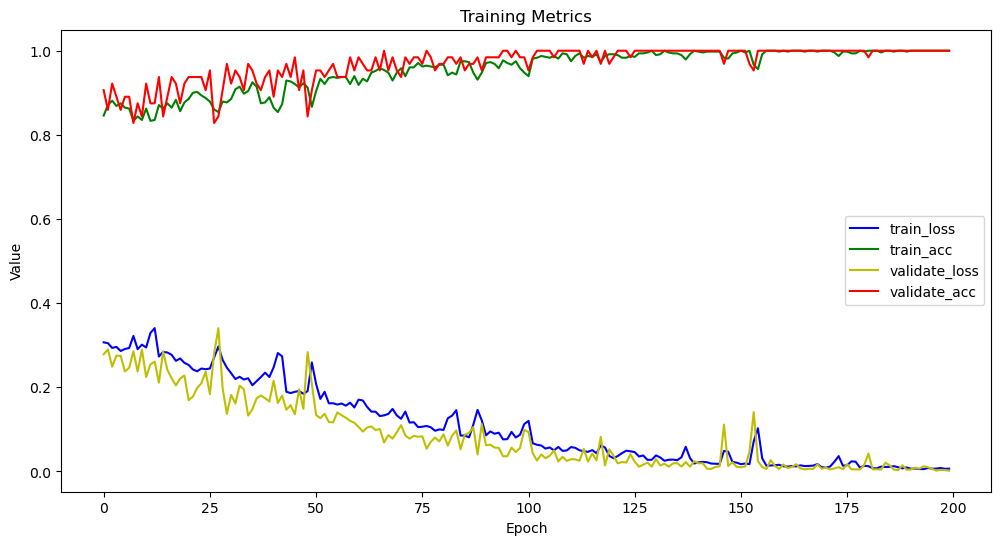

Best validation set accuracy : 1.0


In [6]:
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader, device):
    model = model.to(device)
    train_size = len(train_loader) * batch_size
    val_size = len(val_loader) * batch_size
    best_accuracy = 0.0
    best_model = model

    train_loss = []    
    train_acc = []      
    validate_acc = []
    validate_loss = []
    start_time = time.time()
    print(f"Training start time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()

        loss_epoch = 0.   
        correct_epoch = 0  
        
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            optimizer.zero_grad()
            y_pred = model(seq)
            probabilities = F.softmax(y_pred, dim=1)
            predicted_labels = torch.argmax(probabilities, dim=1)
            correct_epoch += (predicted_labels == labels).sum().item()
            loss = loss_function(y_pred, labels)
            loss_epoch += loss.item()
            loss.backward()
            optimizer.step()

        train_Accuracy  = correct_epoch / train_size 
        train_loss.append(loss_epoch / train_size)
        train_acc.append(train_Accuracy)
        
        with torch.no_grad():
            model.eval()
            loss_validate = 0.
            correct_validate = 0
            for data, label in val_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                probabilities = F.softmax(pre, dim=1)
                predicted_labels = torch.argmax(probabilities, dim=1)
                correct_validate += (predicted_labels == label).sum().item()
                loss = loss_function(pre, label)
                loss_validate += loss.item()
            
            val_accuracy = correct_validate / val_size 
            validate_loss.append(loss_validate / val_size)
            validate_acc.append(val_accuracy)
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model  
        epoch_duration = time.time() - epoch_start_time
        print(f'Epoch: {epoch+1:2}/{epochs} | Time: {epoch_duration:.2f}s | '
              f'train_Loss: {loss_epoch/train_size:10.8f} | train_Accuracy:{train_Accuracy:4.4f} | '
              f'val_Loss:{loss_validate/val_size:10.8f} | validate_Acc:{val_accuracy:4.4f}')
    
    total_duration = time.time() - start_time
    end_time = time.time()

    torch.save(best_model, 'best_model_kanconv_senet.pt')
   
    print(f'\nTraining completion time: {time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))}')
    print(f'Total training time: {total_duration:.2f}s ({total_duration/60:.2f}min)')
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(epochs), train_loss, color='b', label='train_loss')
    plt.plot(range(epochs), train_acc, color='g', label='train_acc')
    plt.plot(range(epochs), validate_loss, color='y', label='validate_loss')
    plt.plot(range(epochs), validate_acc, color='r', label='validate_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training Metrics')
    plt.legend()
    plt.show()
    
    print("Best validation set accuracy :", best_accuracy)

batch_size = 32
epochs =200
model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader, device)